In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from uncertainties import ufloat

Todos

- [x] add case switch for `Batch`, `Job` and `Session`
- [ ] add some examples of feature maps and their corresponding circuit layers
- [x] add CLOPS
- [x] add circuit layer definitions
- [x] create mapping between runtime and $
- [ ] add `Estimator` vs `Sampler` switch → is this needed?!
- [ ] add calculator for getting from (mapping, $n_\text{features}$) → (qubits, depth) → $D_\text{eff}$
- [ ] add more data points for better $D_\text{eff}$
- [ ] try to figure out how $D_\text{eff}$ could be calculated
- [ ] add error mitigation strategies
- [ ] test assumption that error suppression does not change much
- [ ] look into kernel alignment case from E.ON
- [ ] await next inference round from Crédit Mutuel to see if 37k → 220k CLOPS really doesn't affect our runtime

# I&TS Cost Estimator for QML Projects

Caveats:

- classification problem
- supervised learning

Variables

- $t_\text{QPU}$ ... time on QPU
- $n_\text{samples}$ ... number of samples to be inferenced or trained on
- $n_\text{shots}$ ... number of shots per circuit
- $n_\text{qubits}$ ... number of active qubits (how many qubits are being used in the transpiled circuit)
- $n_\text{circuits}$ ... number of circuits
- $d$ ... circuit depth before transpilation
- $d_h$ ... circuit depth after transpilation

## Linear scaling with number of samples

$$  t_\text{QPU} \propto n_\text{samples} $$

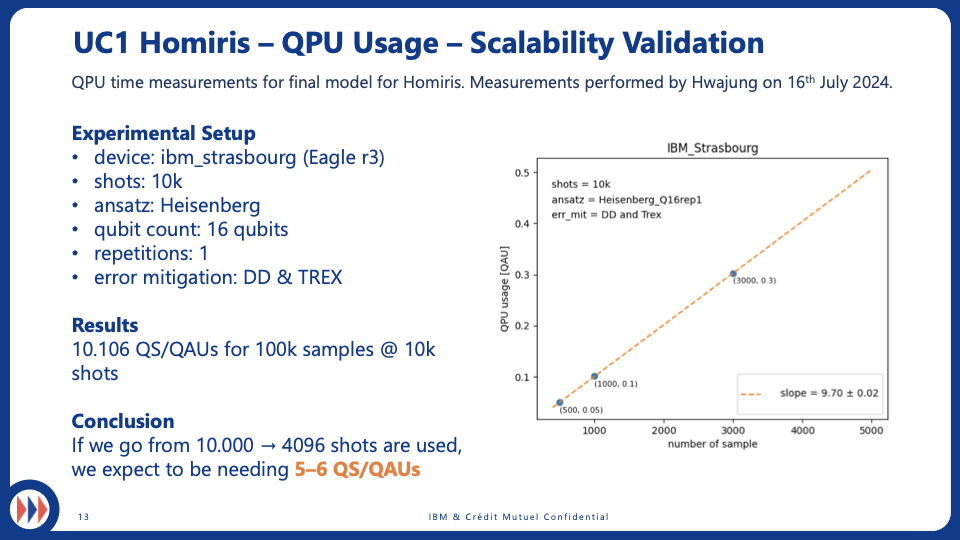

Slide can be found in this [slide deck](https://ibm.ent.box.com/file/1615097701689).

## Linear scaling with number of shots

We assume a linear scaling with the number of shots:

$$ t_\text{QPU} \propto n_\text{shots} $$

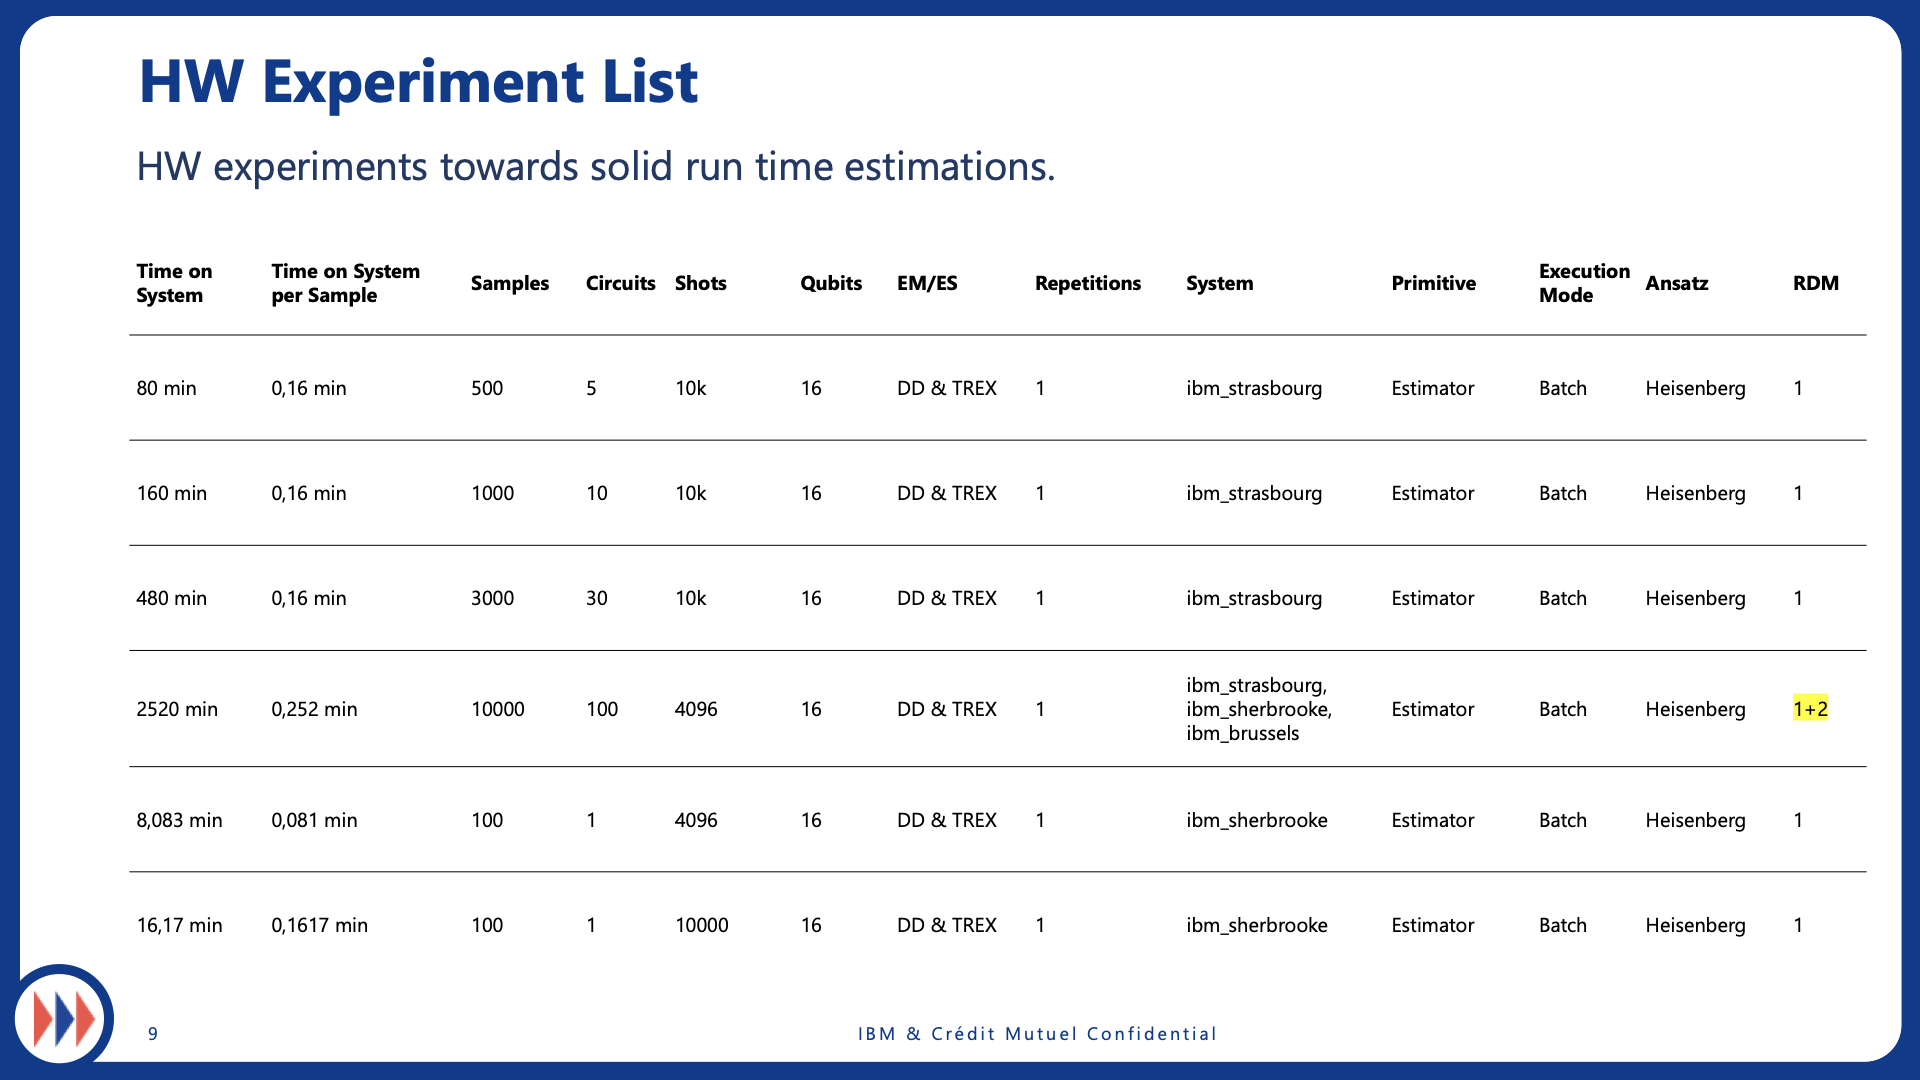

slope: 1.366869918699187e-05
intercept: 0.025013008130081296
σ of residuals: 6.938893903907228e-18


/var/folders/76/3151vn4520156sjr_f_03qy40000gn/T/ipykernel_91465/788577941.py:11: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(linear_model, d['n_shots'], d['t_per_sample_min'])


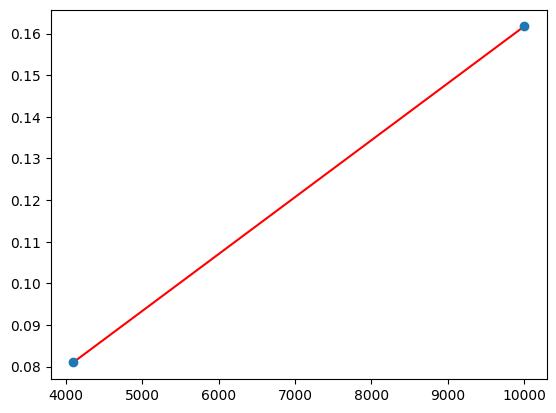

In [19]:
d = pd.DataFrame.from_dict(
    {
        't_per_sample_min' : [0.081, 0.1617],
        'n_shots' : [4096, 10_000]
    }
)

def linear_model(x, slope, intercept):
    return slope * x + intercept

popt, pcov = curve_fit(linear_model, d['n_shots'], d['t_per_sample_min'])

print("slope:", popt[0])
print("intercept:", popt[1])

y_fit = linear_model(d['n_shots'], *popt)

residuals = d['t_per_sample_min'] - y_fit

std_dev = np.std(residuals)

print("σ of residuals:", std_dev)

plt.errorbar(d['n_shots'], d['t_per_sample_min'], yerr=std_dev, fmt='o')
plt.plot(d['n_shots'], y_fit, 'r-')
plt.show()

## Queueing Wait Times

Our estimation excludes qeueuing wait times. The amount of QAUs also effects the priority of the jobs submitted to the queue.

Queueing wait times are hard to predict and vary:

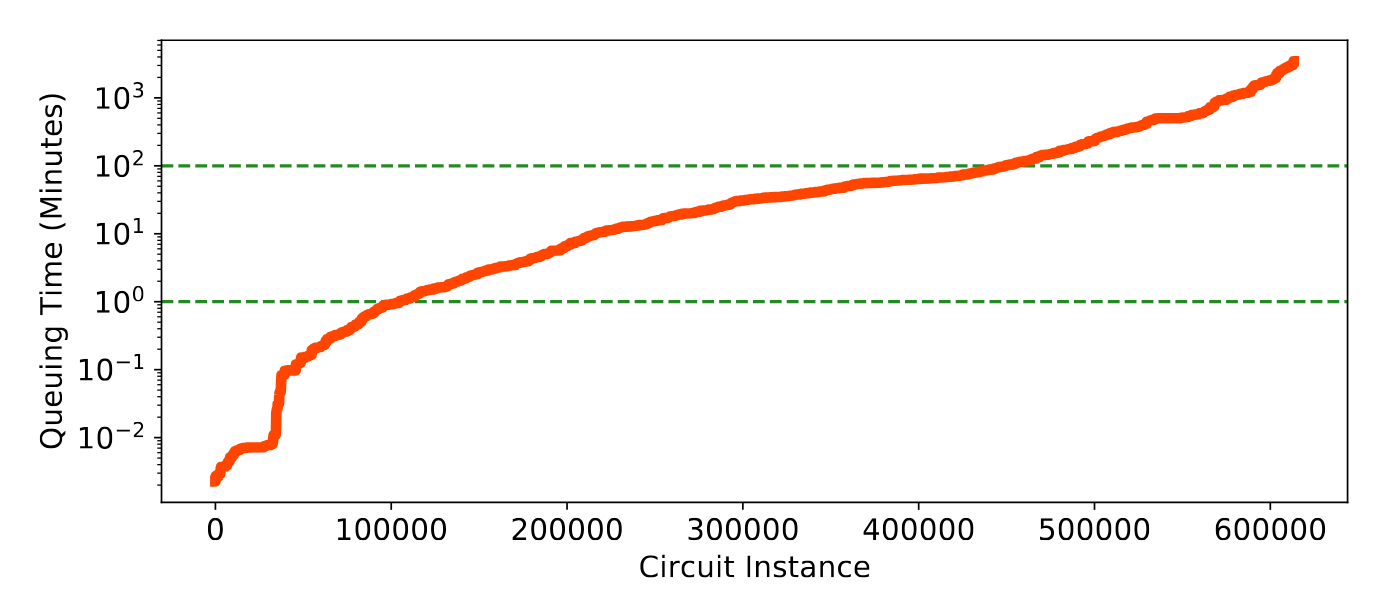

Figure 3 from [Gokul Subramanian Ravi et al. “Quantum Computing in the Cloud: Analyzing job and machine characteristics”](https://arxiv.org/pdf/2203.13121). In: 2021 IEEE International Symposium on Workload Characterization (IISWC). IEEE. 2021, pp. 39–50.

## Previous Work

[Scholten, Travis L., et al. "A Model for Circuit Execution Runtime And Its Implications for Quantum Kernels At Practical Data Set Sizes."](https://arxiv.org/abs/2307.04980) arXiv preprint arXiv:2307.04980 (2023).

For a quantum volume circuits (fully parameterized):

$$ T = \frac{MDKS}{C} $$

with:

- $T$ ... total elapsed time (runtime)
- $M$ ... number of parameterized quantum volume circuits
- $K$ ... number of updates to the parameters
- $D = \log_2{QV}$ ... quantum volume layers
- $S$ ... number of shots
- $C$ ... speed of the system $\text{CLOPS}_\nu$

For $M$ quantum kernel circuits with an effective number of quantum volume layers $D_\text{eff}$:

$$ T = \frac{MSD_\text{eff}}{C} $$

With $D_\text{eff} = \frac{\langle \text{Depth}(U^\dagger (x) U(y))\rangle}{\langle \text{Depth} (QV_{\nu}) \rangle} \cdot \nu$ with

- $\nu = \lceil{\sqrt{2Dn}}\rceil$ with $n$ being the number of qubits and $D$ the number of repetitions of the encoding template
- $QV_j$ ... quantum volume circuit with $j$ number of layers as defined in [2110.14108](https://arxiv.org/pdf/2110.14108)
- $\text{Depth}()$ ... circuit depth after tranpilation for HW
- $x, y$ ... random parameters

$\Rightarrow$ so the big question is how to get from $D \rightarrow D_\text{eff}$?

## $\text{CLOPS}_\nu$ vs $\text{CLOPS}_\text{h}$

<https://www.ibm.com/quantum/blog/quantum-metric-layer-fidelity>

$\text{CLOPS}_\text{h}$ is how fast we can execute hardware aware circuits. $\text{CLOPS}$ or $\text{CLOPS}_\nu$ on the other hand is the speed of how many quantum volume circuits can be executed per unit of time.

> - CLOPS - Circuit layer operations per second, and also known as CLOPS_v, is a measure of how many layers of a Quantum volume circuit (virtual circuit) a QPU (quantum processing unit) can execute per unit of time. Find more information about this metric in the paper Quality, Speed, and Scale: three key attributes to measure the performance of near-term quantum computers(opens in a new tab)
> - CLOPS_h -- A measure of how many layers of a 100x100 circuit (hardware-aware circuit) a QPU (quantum processing unit) can execute per unit of time.

from <https://qiskit.qotlabs.org/guides/qpu-information>

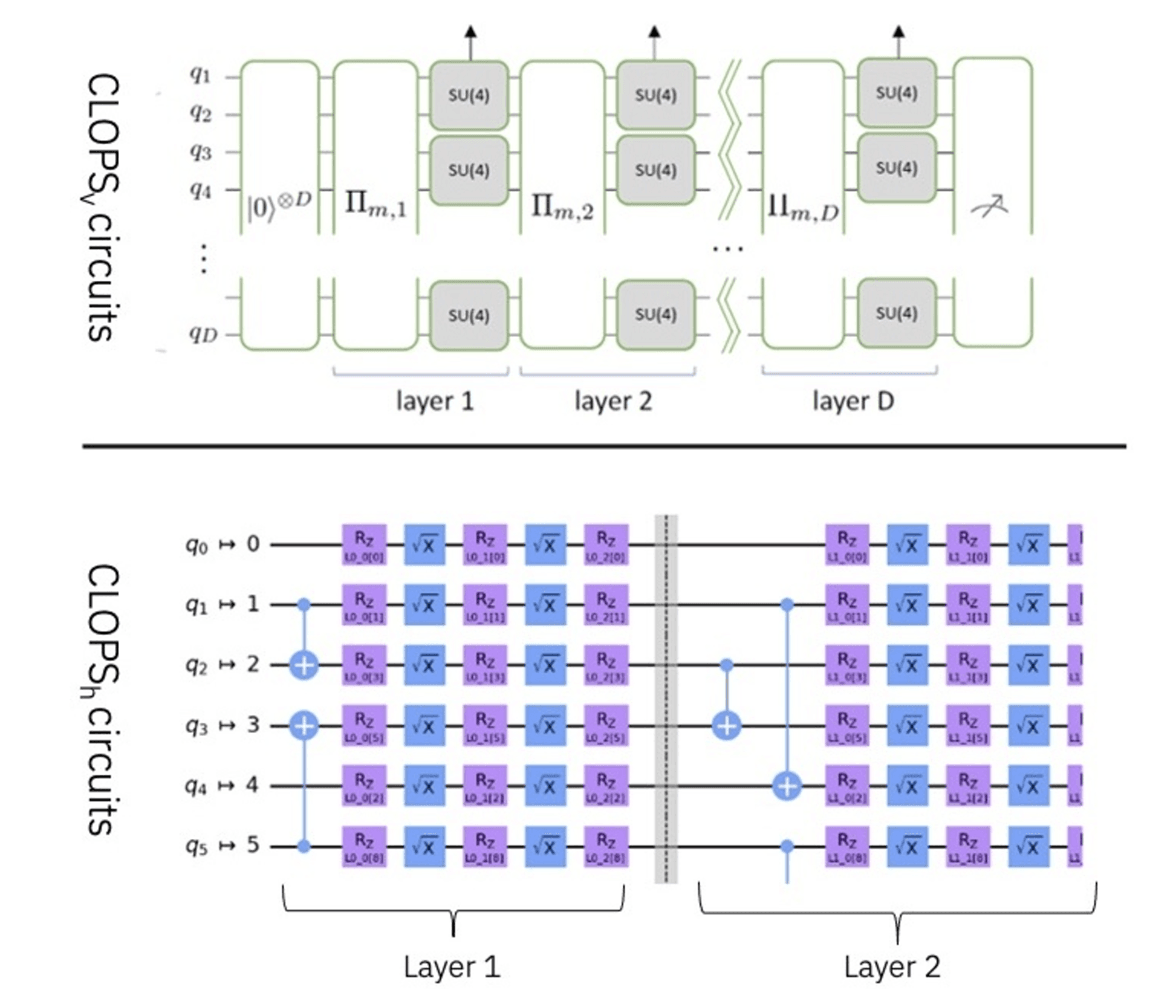

image from <https://www.ibm.com/quantum/blog/quantum-metric-layer-fidelity>

## Empirial Measurement of $D_\text{eff}$

In [133]:
experiments = pd.DataFrame.from_dict(
    {
        'T': [7915, 7962.95, 7663.39, 8.39, 444.9, 313.4], # runtime of experiment in minutes
        'M' : [100_000, 100_000, 100_000, 400, 4406, 2938], # number of circuits, for Homiris: 1 circuit per sample
        'S' : [4096, 4096, 4096, 4096, 4096, 4096], # number of shots
        'C_h': [37_000, 37_000, 37_000, 220_000, 37_000, 37_000], # speed of system CLOPS_h
    }
)

# def its_qml_runtime_model(M, S, D_eff, C_h):
#     return (M * S * D_eff) / C_h

def D_eff(M, S, C_h, T):
    return (C_h*T)/(M*S)

experiments['D_eff'] = experiments.apply(lambda row: D_eff(**row), axis=1)

experiments


,T,M,S,C_h,D_eff
0,7915.00,100000,4096,37000,0.714978
1,7962.95,100000,4096,37000,0.719309
2,7663.39,100000,4096,37000,0.692250
3,8.39,400,4096,220000,1.126587
4,444.90,4406,4096,37000,0.912136
5,313.40,2938,4096,37000,0.963583


In [134]:
experiments.describe()

,T,M,S,C_h,D_eff
count,6.000000,6.000000,6.0,6.000000,6.000000
mean,4051.338333,51290.666667,4096.0,67500.000000,0.854807
std,4161.718785,53373.794614,0.0,74709.437155,0.175111
min,8.390000,400.000000,4096.0,37000.000000,0.692250
25%,346.275000,3305.000000,4096.0,37000.000000,0.716061
50%,4054.145000,52203.000000,4096.0,37000.000000,0.815723
75%,7852.097500,100000.000000,4096.0,37000.000000,0.950721
max,7962.950000,100000.000000,4096.0,220000.000000,1.126587


## Offerings

- Pay-as-you-go: 96$ per minute
- Premium Plan: 48$ per minute

see <https://www.ibm.com/quantum/pricing>

## I&TS QML Cost Estimator

In [135]:
D_eff = ufloat(experiments.describe()['D_eff']['mean'], experiments.describe()['D_eff']['std'])

In [ ]:
def its_qml_cost_estimator(
        M: int = 1,
        S: int = 4096,
        D_eff: ufloat = D_eff,
        C_h: int = 200_000,
        execution_mode: str = 'batch',
        error_mitigation: list = [],
        discount_percentage: float = 0,
) -> dict:
    """I&TS QML Cost Estimator

    Args:
        M (int, optional): number of circuits. Defaults to 1.
        S (int, optional): number of shots. Defaults to 4096.
        D_eff (ufloat, optional): effective depth of the circuit, empirically measured. Defaults to D_eff.
        C_h (int, optional): speed of the system in CLOPS_h (hardware aware). Defaults to 200_000.
        execution_mode (str, optional): switch for the three different execution modes. Defaults to 'batch'.
        error_mitigation (list, optional): list of strings with all used error mitigation methods. Defaults to [].
        discount_percentage (float, optional): discount in percentage (number between 0 and 1) for the Premium Plan. Defaults to 0.

    Raises:
        ValueError: please enter a valid execution mode, when non valid execution mode is provided
        ValueError: session mode currently not supported by the cost estimator, as this execution mode is currently not supported
        ValueError: error mitigation strategies are currently not supported by the cost estimator as error mitigation strategies are currently not supported

    Returns:
        dict: dictionary with the different calculation results: 
        - runtime_minutes: total runtime in minutes
        - runtime_hours: total runtime in hours
        - runtime_QAUs: total runtime converted into QAUs (within 28 days), calculated with simple division by 1600 mins
        - costs_dollar_premium: total price in dollar for Premium Plan with discount
        - costs_dollar_paygo: total price in dollar for using Pay-as-you-go
    """
    
    PRICE_PER_MINUTE_DOLLAR_PREMIUM = 48
    PRICE_PER_MINUTE_DOLLAR_PAYGO = 96

    if execution_mode not in ['batch', 'session', 'job']:
        raise ValueError('please enter a valid execution mode')
    if execution_mode in ['batch', 'job']:
        pass
    if execution_mode == 'session':
        raise ValueError(
            'session mode currently not supported by the cost estimator')

    if len(error_mitigation) != 0:
        raise ValueError(
            'error mitigation strategies are currently not supported by the cost estimator')

    runtime_min = (M * S * D_eff) / C_h

    r = {
        'runtime_minutes': runtime_min,
        'runtime_hours': runtime_min / 60,
        'runtime_QAUs': runtime_min / 1600,
        'costs_dollar_premium': runtime_min * PRICE_PER_MINUTE_DOLLAR_PREMIUM * (1-discount_percentage),
        'costs_dollar_paygo': runtime_min * PRICE_PER_MINUTE_DOLLAR_PAYGO
    }

    return r

In [137]:
its_qml_cost_estimator(M=100000, S=4096, C_h=37000)

{'runtime_minutes': 9462.946050248704+/-1938.5288308213717,
 'runtime_hours': 157.71576750414505+/-32.30881384702286,
 'runtime_QAUs': 5.91434128140544+/-1.2115805192633573,
 'costs_dollar_premium': 454221.41041193774+/-93049.38387942585,
 'costs_dollar_paygo': 908442.8208238755+/-186098.7677588517}

In [143]:
'runtime: {:.2f} hours'.format(its_qml_cost_estimator(M=100000, S=4096, C_h=37000)['runtime_hours'])

'runtime: 157.72+/-32.31 hours'